In [1]:
import numpy as np
import cvxpy as cp
import sklearn
import sklearn.datasets
from sklearn.ensemble import RandomForestRegressor
import gurobipy
import mosek
import matplotlib.pyplot as plt
from multiprocessing import Pool
import time
import os
import seaborn as sns
import pandas as pd
# My Code
import LearningMethod as lm
import DataGeneration as dg
import LinearProgramMethod as lpm
import OnlineMethod as om

In [12]:
focus = "degree"
globals()[focus + "_set"] = [1]
total_trial = 30
methods = ['ExpRbf']
for i in range(len(methods)):
    globals()[f"Loss_{methods[i]}"] = np.zeros((total_trial, len(globals()[focus + "_set"])))
    globals()[f"Error_{methods[i]}"] = np.zeros((total_trial, len(globals()[focus + "_set"])))
    globals()[f"Norm_Err_{methods[i]}"] = np.zeros((total_trial, len(globals()[focus + "_set"])))

In [2]:
# Generate Fractional Knapsack Samples
benchmark = 1
dim_features = 5
dim_decision = 10
price = np.random.randint(low=1, high=1000, size=dim_decision)
lower = np.amax(price)
upper = (np.random.rand()-1)*lower + np.sum(price)
Budget = [(upper-lower)*np.random.rand() + lower]
Coeff_Mat = np.random.binomial(n=1, p=0.5, size = (dim_decision, dim_features))
Theta_true = -np.concatenate((Coeff_Mat, np.zeros((dim_decision+1, dim_features))), axis=0)

In [7]:
N_train = 500
# N_valid = 200
N_test = 1000
degree = 1
additive_noise = 0.0
scale_noise_uni = 0.0
scale_noise_div = 0.0
attack_threshold = None
attack_power = 0.0
z_train, c_train, A_train, b_train = dg.GenerateFractionalKnapsack(N_samples=N_train, dim_features=dim_features, dim_decision=dim_decision, Coeff_Mat=Coeff_Mat, price=price, Budget=Budget,
                                    degree=degree, additive_noise=additive_noise, scale_noise_uni=scale_noise_uni, scale_noise_div=scale_noise_div, attack_threshold = attack_threshold, attack_power = attack_power)
# z_valid, c_valid, A_valid, b_valid = dg.GenerateFractionalKnapsack(N_samples=N_valid, dim_features=dim_features, dim_decision=dim_decision, Coeff_Mat=Coeff_Mat, price=price, Budget=Budget,
#                                     degree=degree, additive_noise=additive_noise, scale_noise_uni=scale_noise_uni, scale_noise_div=scale_noise_div, attack_threshold = attack_threshold, attack_power = attack_power)
z_test, c_test, A_test, b_test = dg.GenerateFractionalKnapsack(N_samples=N_test, dim_features=dim_features, dim_decision=dim_decision, Coeff_Mat=Coeff_Mat, price=price, Budget=Budget,
                                    degree=degree, additive_noise=additive_noise, scale_noise_uni=scale_noise_uni, scale_noise_div=scale_noise_div, attack_threshold = attack_threshold, attack_power = attack_power)

In [5]:
# Generate Shortest Path Samples
benchmark = 2
dim_edge_vert = 4
dim_edge_hori = 4
dim_features = 6
dim_cost = dim_edge_hori * (dim_edge_vert + 1) + (dim_edge_hori + 1) * dim_edge_vert
Coeff_Mat = np.random.binomial(n=1, p=0.5, size = (dim_cost, dim_features))

In [6]:
N_train = 200
# N_valid = 200
N_test = 1000
degree = 4
additive_noise = 0.0
scale_noise_uni = 0.0
scale_noise_div = 0.0
attack_threshold = None
attack_power = 0.0
z_train, c_train, A_train, b_train = dg.GenerateShortestPath(N_samples = N_train, dim_features = dim_features, Coeff_Mat=Coeff_Mat,
                                                            dim_edge_vert = dim_edge_vert, dim_edge_hori = dim_edge_hori,
                                                            degree=degree, additive_noise=additive_noise, scale_noise_uni=scale_noise_uni, scale_noise_div=scale_noise_div, attack_threshold=attack_threshold, attack_power=attack_power)
# z_valid, c_valid, A_valid, b_valid = dg.GenerateShortestPath(N_samples = N_valid, dim_features = dim_features, Coeff_Mat=Coeff_Mat,
#                                                             dim_edge_vert = dim_edge_vert, dim_edge_hori = dim_edge_hori,
#                                                             degree=degree, additive_noise=additive_noise, scale_noise_uni=scale_noise_uni, scale_noise_div=scale_noise_div, attack_threshold=attack_threshold, attack_power=attack_power)
z_test, c_test, A_test, b_test = dg.GenerateShortestPath(N_samples = N_test, dim_features = dim_features, Coeff_Mat=Coeff_Mat,
                                                            dim_edge_vert = dim_edge_vert, dim_edge_hori = dim_edge_hori,
                                                            degree=degree, additive_noise=additive_noise, scale_noise_uni=scale_noise_uni, scale_noise_div=scale_noise_div, attack_threshold=attack_threshold, attack_power=attack_power)

In [8]:
# Compute Optimal Solutions
start = time.time()
basic_train, nonb_train, solution_train = lpm.ComputeBasis(c=c_train, A=A_train, b=b_train)
#basic_valid, nonb_valid, solution_valid = lpm.ComputeBasis(c=c_valid, A=A_valid, b=b_valid)
basic_test, nonb_test, solution_test = lpm.ComputeBasis(c=c_test, A=A_test, b=b_test)
print("Time cost", time.time() - start)

Time cost 3.2414863109588623


Method Random Forest
Training samples 1000
Time Cost 0.38739728927612305
Loss 0.21948659456220446 Error 0.49859117315434326 Normalized Error 0.49158763197470406


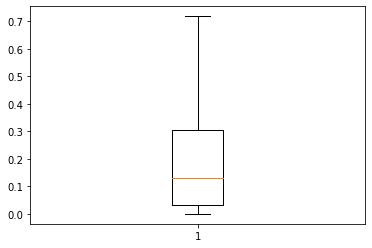

In [18]:
# Tuning Hyperparameters
# Random Forest
# No Theta, directly predict c
alg = 'RF'
print("Method Random Forest")
print("Training samples", N_train)
start = time.time()
regr = RandomForestRegressor(random_state=0)
regr.fit(z_train, c_train)
hat_c = regr.predict(z_test)
globals()["time_"+alg] = time.time() - start
print("Time Cost", globals()["time_"+alg])
globals()["loss_"+alg], globals()["error_"+alg], globals()["norm_err_"+alg] = lpm.ComputeLoss(benchmark = benchmark, A=A_test, b=b_test, c=c_test, z=z_test,
                                                                                         direct=True, hat_c=hat_c, solved = True, solution=solution_test)
print("Loss", np.average(globals()["loss_"+alg]), "Error", np.average(globals()["error_"+alg]), "Normalized Error", np.average(globals()["norm_err_"+alg]))
plt.boxplot(globals()["loss_"+alg], showfliers = False)
plt.show()

Method Ordinary Least Squares
Training samples 1000
Time Cost 3.307584762573242
Loss 0.19415475388499986 Error 0.4533149522010404 Normalized Error 0.45179293804347115


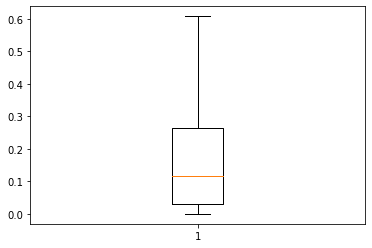

In [19]:
# Tuning Hyperparameters
# Ordinary Least Squares
alg = 'OLS'
print("Method Ordinary Least Squares")
print("Training samples", N_train)
start = time.time()
globals()["Theta_"+alg] = lm.OrdinaryLeastSquares(A = A_train, b = b_train, c = c_train, z = z_train)
globals()["time_"+alg] = time.time() - start
print("Time Cost", globals()["time_"+alg])
globals()["loss_"+alg], globals()["error_"+alg], globals()["norm_err_"+alg] = lpm.ComputeLoss(benchmark = benchmark,A = A_test, b = b_test, c = c_test, z = z_test, direct = False,
                                                                                                Theta = globals()["Theta_"+alg], solved = True, solution = solution_test)
print("Loss", np.average(globals()["loss_"+alg]), "Error", np.average(globals()["error_"+alg]), "Normalized Error", np.average(globals()["norm_err_"+alg]))
plt.boxplot(globals()["loss_"+alg], showfliers = False)
plt.show()

Method Ridge Regression
Training samples 1000
Time Cost 6.661448001861572
Loss 0.15194116180577058 Error 0.22452946184714642 Normalized Error 0.04323134260851218


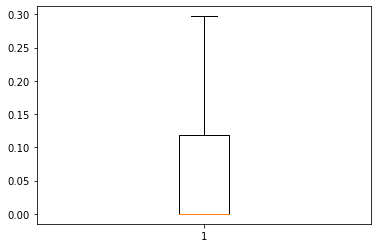

In [33]:
# Tuning Hyperparameters
# Ridge Regression
alg = 'Ridge'
print("Method Ridge Regression")
print("Training samples", N_train)
start = time.time()
globals()["Theta_"+alg] = lm.RidgeRegression(A = A_train, b = b_train, c = c_train,  z = z_train, regular_const = 1e0)
globals()["time_"+alg] = time.time() - start
print("Time Cost", globals()["time_"+alg])
globals()["loss_"+alg], globals()["error_"+alg], globals()["norm_err_"+alg] = lpm.ComputeLoss(benchmark = benchmark,A = A_test, b = b_test, c = c_test, z = z_test, direct = False,
                                                                                                Theta = globals()["Theta_"+alg], solved = True, solution = solution_test)
print("Loss", np.average(globals()["loss_"+alg]), "Error", np.average(globals()["error_"+alg]), "Normalized Error", np.average(globals()["norm_err_"+alg]))
plt.boxplot(globals()["loss_"+alg], showfliers = False)
plt.show()

In [ ]:
# Tuning Hyperparameters
# Margin Learning
# Do not need true c
# Do not need solution x but basis
alg = 'ML'
print("Method SVM Margin Learning")
print("Training samples", N_train)
start = time.time()
globals()["Theta_"+alg] = lm.MarginLearning(A = A_train, b = b_train, z = z_train, basic = basic_train, nonb = nonb_train, 
                                            regular_const = 1e-2)
globals()["time_"+alg] = time.time() - start
print("Time Cost", globals()["time_"+alg])
globals()["loss_"+alg], globals()["error_"+alg], globals()["norm_err_"+alg] = lpm.ComputeLoss(benchmark = benchmark,A = A_test, b = b_test, c = c_test, z = z_test, direct = False,
                                                                                                Theta = globals()["Theta_"+alg], solved = True, solution = solution_test)
print("Loss", np.average(globals()["loss_"+alg]), "Error", np.average(globals()["error_"+alg]), "Normalized Error", np.average(globals()["norm_err_"+alg]))
plt.boxplot(globals()["loss_"+alg], showfliers = False)
plt.show()

Method Poly-Kernelized SVM Margin Learning
Training samples 500
Time Cost 50.10742902755737
Loss 0.003481790113631899 Error 2.385362348812643 Normalized Error 0.9626135449495582


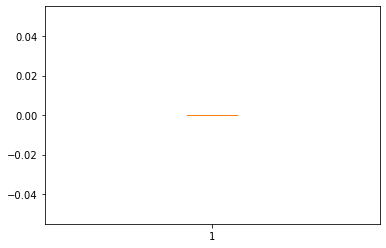

In [106]:
# Tuning Hyperparameters
# Kernelized Margin Learning
# Do not need true c
# Do not need solution x but basis
alg = 'PolyKer'
ker_z_train = lm.PolyKernel(z = z_train, benchmark_z = z_train, gamma=1.0, degree=2, coef0=1.0)
ker_z_test = lm.PolyKernel(z = z_test, benchmark_z = z_train, gamma=1.0, degree=2, coef0=1.0)
print("Method Poly-Kernelized SVM Margin Learning")
print("Training samples", N_train)
start = time.time()
globals()["Theta_"+alg] = lm.KernelizedMarginLearning(A = A_train, b = b_train, z = ker_z_train, basic = basic_train, nonb = nonb_train,
                                                      regular_const=1e-1)
globals()["time_"+alg] = time.time() - start
print("Time Cost", globals()["time_"+alg])
globals()["loss_"+alg], globals()["error_"+alg], globals()["norm_err_"+alg] = lpm.ComputeLoss(benchmark = benchmark,A = A_test, b = b_test, c = c_test, z = ker_z_test, direct = False,
                                                                                                Theta = globals()["Theta_"+alg], solved = True, solution = solution_test)
print("Loss", np.average(globals()["loss_"+alg]), "Error", np.average(globals()["error_"+alg]), "Normalized Error", np.average(globals()["norm_err_"+alg]))
plt.boxplot(globals()["loss_"+alg], showfliers = False)
plt.show()

Method Rbf Kernelized SVM Margin Learning
Training samples 500
Time Cost 48.845229625701904
Loss 0.001363436132815057 Error 4.356803827566979 Normalized Error 0.9613189211255628


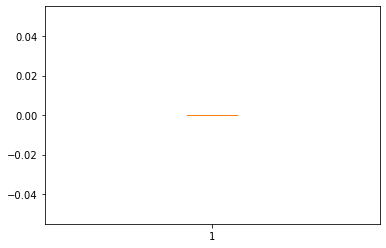

In [9]:
# Tuning Hyperparameters
# Kernelized Margin Learning
# Do not need true c
# Do not need solution x but basis
alg = 'ExpRbf'
ker_z_train = lm.ExpKernel(z = z_train, benchmark_z = z_train, gamma=1e0)
ker_z_test = lm.ExpKernel(z = z_test, benchmark_z = z_train, gamma=1e0)
print("Method Rbf Kernelized SVM Margin Learning")
print("Training samples", N_train)
start = time.time()
globals()["Theta_"+alg] = lm.KernelizedMarginLearning(A = A_train, b = b_train, z = ker_z_train, basic = basic_train, nonb = nonb_train,
                                                      regular_const=1e-3)
globals()["time_"+alg] = time.time() - start
print("Time Cost", globals()["time_"+alg])
globals()["loss_"+alg], globals()["error_"+alg], globals()["norm_err_"+alg] = lpm.ComputeLoss(benchmark = benchmark,A = A_test, b = b_test, c = c_test, z = ker_z_test, direct = False,
                                                                                                Theta = globals()["Theta_"+alg], solved = True, solution = solution_test)
print("Loss", np.average(globals()["loss_"+alg]), "Error", np.average(globals()["error_"+alg]), "Normalized Error", np.average(globals()["norm_err_"+alg]))
plt.boxplot(globals()["loss_"+alg], showfliers = False)
plt.show()

Method SPO+
Training samples 1000


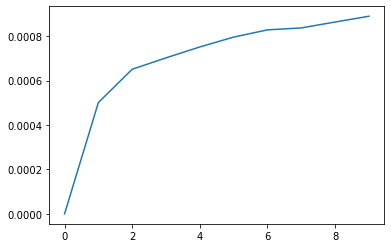

Time Cost 73.65812611579895
Loss 0.5987875151330696 Error 1.0007558631960765 Normalized Error 1.3691127547519202


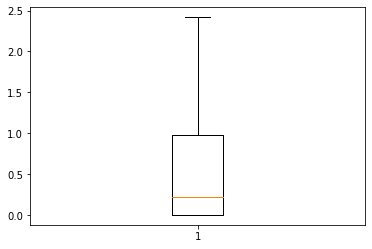

In [12]:
# Tuning Hyperparameters
# SPO+
alg = 'SPO'
print("Method SPO+")
print("Training samples", N_train)
start = time.time()
globals()["Theta_"+alg] = lm.SPOplus(A = A_train, b = b_train, c = c_train, z = z_train, 
                                     regular_const = 1e-4, step_size = 1e-1, batch_size = 5, max_iter = 1e3, 
                                     solved = True, solution = solution_train)
globals()["time_"+alg] = time.time() - start
print("Time Cost", globals()["time_"+alg])
globals()["loss_"+alg], globals()["error_"+alg], globals()["norm_err_"+alg] = lpm.ComputeLoss(benchmark = benchmark,A = A_test, b = b_test, c = c_test, z = z_test, direct = False,
                                                                                                Theta = globals()["Theta_"+alg], solved = True, solution = solution_test)
print("Loss", np.average(globals()["loss_"+alg]), "Error", np.average(globals()["error_"+alg]), "Normalized Error", np.average(globals()["norm_err_"+alg]))
plt.boxplot(globals()["loss_"+alg], showfliers = False)
plt.show()

Method Naive OGD
Training samples 500
Time Cost 0.006976127624511719
Loss 1.8388770292478134 Error 2.0838786030458283 Normalized Error 1.4042543516428285


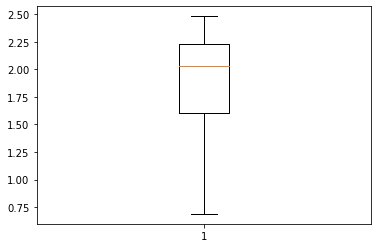

In [17]:
# Tuning Hyperparameters
# Naive Online Gradient Descent
# Do not need true c
alg = 'NOGD'
print("Method Naive OGD")
print("Training samples", N_train)
start = time.time()
globals()["Theta_"+alg] = lm.NaiveOnlineGradientDescent(A = A_train, b = b_train, z = z_train, 
                                                        step_size = 1e-3, solution = solution_train, radius = 50)
globals()["time_"+alg] = time.time() - start
print("Time Cost", globals()["time_"+alg])
globals()["loss_"+alg], globals()["error_"+alg], globals()["norm_err_"+alg] = lpm.ComputeLoss(benchmark = benchmark,A = A_test, b = b_test, c = c_test, z = z_test, direct = False,
                                                                                                Theta = globals()["Theta_"+alg], solved = True, solution = solution_test)
print("Loss", np.average(globals()["loss_"+alg]), "Error", np.average(globals()["error_"+alg]), "Normalized Error", np.average(globals()["norm_err_"+alg]))
plt.boxplot(globals()["loss_"+alg], showfliers = False)
plt.show()

Method SVM OGD
Training samples 1000
Time Cost 0.0670003890991211
Loss 0.38048191031371514 Error 0.9994669064078309 Normalized Error 1.3105632225268369


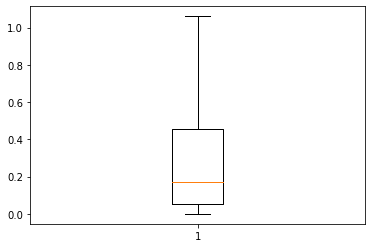

In [17]:
# Tuning Hyperparameters
# SVM Margin Online Gradient Descent
# Do not need true c
# Do not need solution x but basis
alg = 'SVMOGD'
print("Method SVM OGD")
print("Training samples", N_train)
start = time.time()
globals()["Theta_"+alg] = lm.SVM_OGD(A = A_train, b = b_train, z = z_train, basic = basic_train, nonb = nonb_train,
                                     step_size = 1e-4, radius = 1.1* np.linalg.norm(Coeff_Mat, 'f'), regular_const=1e-2)
globals()["time_"+alg] = time.time() - start
print("Time Cost", globals()["time_"+alg])
globals()["loss_"+alg], globals()["error_"+alg], globals()["norm_err_"+alg] = lpm.ComputeLoss(benchmark = benchmark,A = A_test, b = b_test, c = c_test, z = z_test, direct = False,
                                                                                                Theta = globals()["Theta_"+alg], solved = True, solution = solution_test)
print("Loss", np.average(globals()["loss_"+alg]), "Error", np.average(globals()["error_"+alg]), "Normalized Error", np.average(globals()["norm_err_"+alg]))
plt.boxplot(globals()["loss_"+alg], showfliers = False)
plt.show()

In [ ]:
for trial in range(total_trial):
    # Generate Fractional Knapsack Samples
    benchmark = 1
    dim_features = 5
    dim_decision = 10
    price = np.random.randint(low=1, high=1000, size=dim_decision)
    lower = np.amax(price)
    upper = (np.random.rand()-1)*lower + np.sum(price)
    Budget = [(upper-lower)*np.random.rand() + lower]
    Coeff_Mat = np.random.binomial(n=1, p=0.5, size = (dim_decision, dim_features))
    Theta_true = -np.concatenate((Coeff_Mat, np.zeros((dim_decision+1, dim_features))), axis=0)
    print("*********************************************************")
    print("Trial", trial + 1)
    
    N_train = 500
    # N_valid = 200
    N_test = 1000
    degree = 1
    additive_noise = 0.0
    scale_noise_uni = 0.0
    scale_noise_div = 0.0
    attack_threshold = None
    attack_power = 0.0
    z_train, c_train, A_train, b_train = dg.GenerateFractionalKnapsack(N_samples=N_train, dim_features=dim_features, dim_decision=dim_decision, Coeff_Mat=Coeff_Mat, price=price, Budget=Budget,
                                        degree=degree, additive_noise=additive_noise, scale_noise_uni=scale_noise_uni, scale_noise_div=scale_noise_div, attack_threshold = attack_threshold, attack_power = attack_power)
    # z_valid, c_valid, A_valid, b_valid = dg.GenerateFractionalKnapsack(N_samples=N_valid, dim_features=dim_features, dim_decision=dim_decision, Coeff_Mat=Coeff_Mat, price=price, Budget=Budget,
    #                                     degree=degree, additive_noise=additive_noise, scale_noise_uni=scale_noise_uni, scale_noise_div=scale_noise_div, attack_threshold = attack_threshold, attack_power = attack_power)
    z_test, c_test, A_test, b_test = dg.GenerateFractionalKnapsack(N_samples=N_test, dim_features=dim_features, dim_decision=dim_decision, Coeff_Mat=Coeff_Mat, price=price, Budget=Budget,
                                        degree=degree, additive_noise=additive_noise, scale_noise_uni=scale_noise_uni, scale_noise_div=scale_noise_div, attack_threshold = attack_threshold, attack_power = attack_power)
    # Compute Optimal Solutions
    start = time.time()
    basic_train, nonb_train, solution_train = lpm.ComputeBasis(c=c_train, A=A_train, b=b_train)
    #basic_valid, nonb_valid, solution_valid = lpm.ComputeBasis(c=c_valid, A=A_valid, b=b_valid)
    basic_test, nonb_test, solution_test = lpm.ComputeBasis(c=c_test, A=A_test, b=b_test)
    print("Time cost", time.time() - start)
    
    
    # Kernelized Margin Learning
    # Do not need true c
    # Do not need solution x but basis
    alg = 'ExpRbf'
    ker_z_train = lm.ExpKernel(z = z_train, benchmark_z = z_train, gamma=1e-1)
    ker_z_test = lm.ExpKernel(z = z_test, benchmark_z = z_train, gamma=1e-1)
    print("Method Kernelized SVM Margin Learning")
    print("Training samples", N_train)
    start = time.time()
    globals()["Theta_"+alg] = lm.KernelizedMarginLearning(A = A_train, b = b_train, z = ker_z_train, basic = basic_train, nonb = nonb_train,
                                                          regular_const=0)
    globals()["time_"+alg] = time.time() - start
    print("Time Cost", globals()["time_"+alg])
    globals()["loss_"+alg], globals()["error_"+alg], globals()["norm_err_"+alg] = lpm.ComputeLoss(benchmark = benchmark,A = A_test, b = b_test, c = c_test, z = ker_z_test, direct = False,
                                                                                                    Theta = globals()["Theta_"+alg], solved = True, solution = solution_test)
    print("Loss", np.average(globals()["loss_"+alg]), "Error", np.average(globals()["error_"+alg]), "Normalized Error", np.average(globals()["norm_err_"+alg]))
    mark = 0
    for j in range(len(globals()[focus + "_set"])):
        if globals()[focus] == globals()[focus + "_set"][j]:
            mark = j
    globals()["Loss_" + alg][trial][mark] = np.average(globals()["loss_" + alg])
    globals()["Error_" + alg][trial][mark] = np.average(globals()["error_" + alg])
    globals()["Norm_Err_" + alg][trial][mark] = np.average(globals()["norm_err_" + alg])

*********************************************************
Trial 1
Time cost 3.4068288803100586
Method Kernelized SVM Margin Learning
Training samples 500


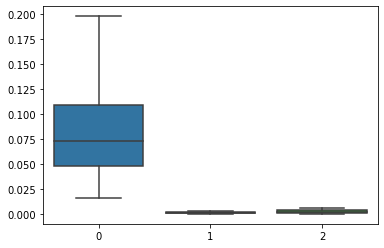

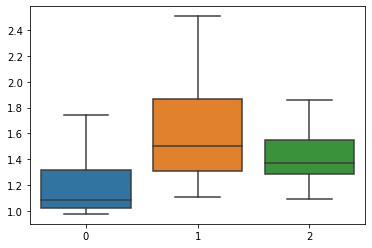

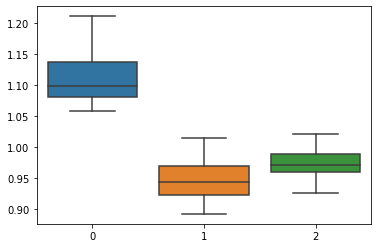

In [59]:
# degree 4
i = 0
data_name = ["Loss", "Error", "Norm_Err"]
for data in data_name:
    tmp = np.zeros((total_trial, len(methods)))
    for j in range(len(methods)):
        tmp[:, j] = globals()[data+"_"+methods[j]].T[i]
    np.savetxt(os.path.join('Degree', f"{data}_degree_{degree_set[i]}_Ker"), tmp)
    sns.boxplot(data = tmp, showfliers = False)
    plt.show()

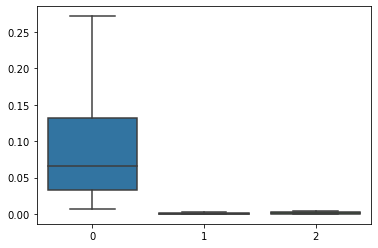

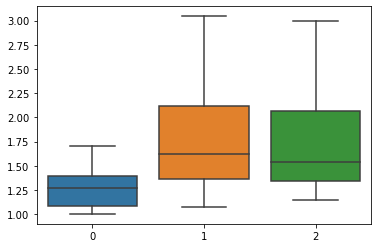

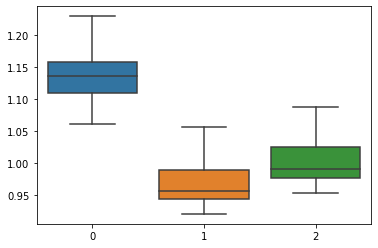

In [95]:
# degree 6
i = 1
data_name = ["Loss", "Error", "Norm_Err"]
for data in data_name:
    tmp = np.zeros((total_trial, len(methods)))
    for j in range(len(methods)):
        tmp[:, j] = globals()[data+"_"+methods[j]].T[i]
    np.savetxt(os.path.join('Degree', f"{data}_degree_{degree_set[i]}_Ker"), tmp)
    sns.boxplot(data = tmp, showfliers = False)
    plt.show()

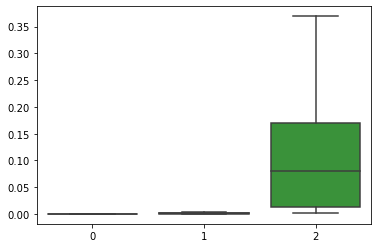

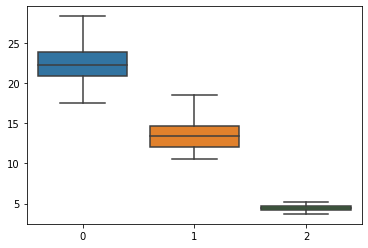

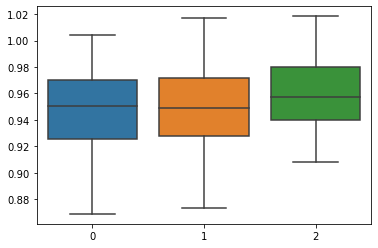

In [112]:
# degree 1
i = 2
data_name = ["Loss", "Error", "Norm_Err"]
for data in data_name:
    tmp = np.zeros((total_trial, len(methods)))
    for j in range(len(methods)):
        tmp[:, j] = globals()[data+"_"+methods[j]].T[i]
    np.savetxt(os.path.join('Degree', f"{data}_degree_{degree_set[i]}_Ker"), tmp)
    sns.boxplot(data = tmp, showfliers = False)
    plt.show()

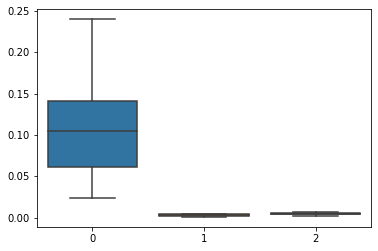

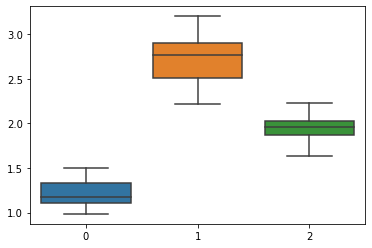

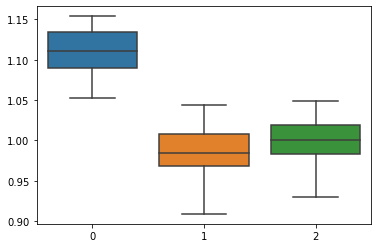

In [110]:
# degree 2
i = 3
data_name = ["Loss", "Error", "Norm_Err"]
for data in data_name:
    tmp = np.zeros((total_trial, len(methods)))
    for j in range(len(methods)):
        tmp[:, j] = globals()[data+"_"+methods[j]].T[i]
    np.savetxt(os.path.join('Degree', f"{data}_degree_{degree_set[i]}_Ker"), tmp)
    sns.boxplot(data = tmp, showfliers = False)
    plt.show()

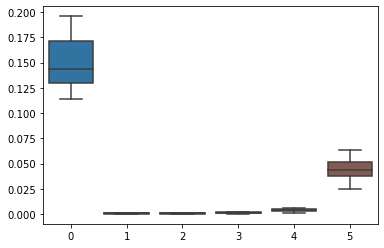

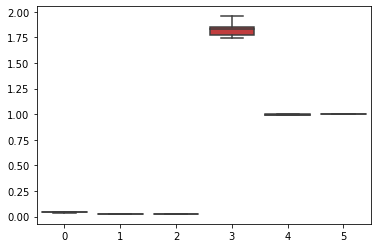

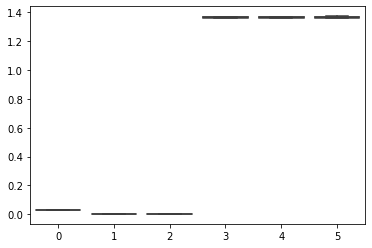

In [36]:
i = 0
data_name = ["Loss", "Error", "Norm_Err"]
for data in data_name:
    tmp = np.zeros((total_trial, len(methods)))
    for j in range(len(methods)):
        tmp[:, j] = globals()[data+"_"+methods[j]].T[i]
    np.savetxt(os.path.join('Attack_Power', f"{data}_power_{attack_power_set[i]}"), tmp)
    sns.boxplot(data = tmp, showfliers = False)
    plt.show()

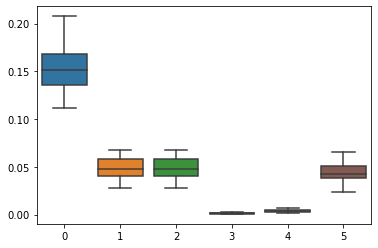

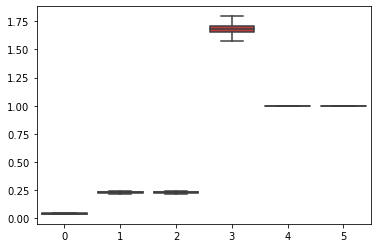

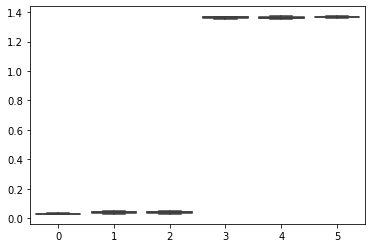

In [4]:
i = 1
data_name = ["Loss", "Error", "Norm_Err"]
for data in data_name:
    tmp = np.zeros((total_trial, len(methods)))
    for j in range(len(methods)):
        tmp[:, j] = globals()[data+"_"+methods[j]].T[i]
    np.savetxt(os.path.join('Attack_Power', f"{data}_power_{attack_power_set[i]}"), tmp)
    sns.boxplot(data = tmp, showfliers = False)
    plt.show()

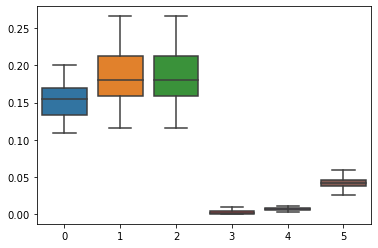

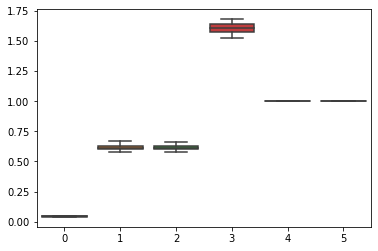

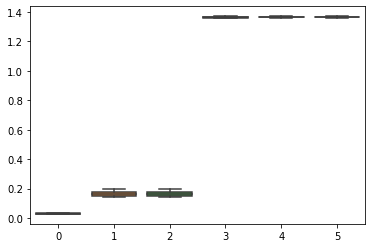

In [14]:
i = 2
data_name = ["Loss", "Error", "Norm_Err"]
for data in data_name:
    tmp = np.zeros((total_trial, len(methods)))
    for j in range(len(methods)):
        tmp[:, j] = globals()[data+"_"+methods[j]].T[i]
    np.savetxt(os.path.join('Attack_Power', f"{data}_power_{attack_power_set[i]}"), tmp)
    sns.boxplot(data = tmp, showfliers = False)
    plt.show()

In [24]:
print(globals()[data+"_"+methods[j]].T[i])

[0.12922369 0.11743162 0.16924198 0.16297437 0.13077465 0.15823413
 0.14790405 0.17031298 0.15833414 0.18191709 0.15625121 0.19096635
 0.15535143 0.15031566 0.18060388 0.15342378 0.12405103 0.21309579
 0.11811923 0.15956173 0.14396253 0.1942669  0.13780931 0.15165267
 0.12863871 0.15474835 0.12454046 0.13749102 0.17122848 0.17815233]


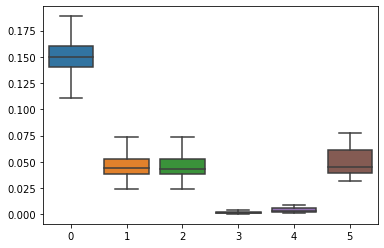

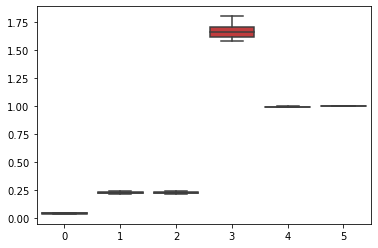

In [32]:
i = 1
data = np.array([Reg_RF.T[i], Reg_OLS.T[i], Reg_Ridge.T[i], Reg_ML.T[i], Reg_SPO.T[i], Reg_SVMOGD.T[i]]).T
np.savetxt(os.path.join('Attack_Power', f"Loss_power{attack_power_set[i]}"), data)
sns.boxplot(data = data, showfliers = False)
plt.show()

data = np.array([Err_RF.T[i], Err_OLS.T[i], Err_Ridge.T[i], Err_ML.T[i], Err_SPO.T[i], Err_SVMOGD.T[i]]).T
np.savetxt(os.path.join('Attack_Power', f"Error_power{attack_power_set[i]}"), data)
sns.boxplot(data = data, showfliers = False)
plt.show()

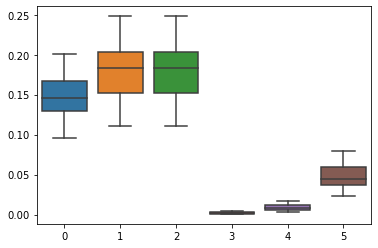

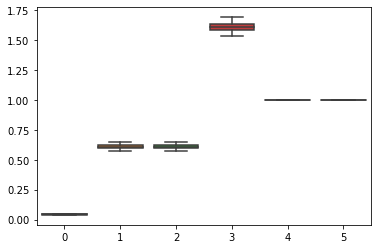

In [46]:
i = 2
data = np.array([Reg_RF.T[i], Reg_OLS.T[i], Reg_Ridge.T[i], Reg_ML.T[i], Reg_SPO.T[i], Reg_SVMOGD.T[i]]).T
np.savetxt(os.path.join('Attack_Power', f"Loss_power{attack_power_set[i]}"), data)
sns.boxplot(data = data, showfliers = False)
plt.show()

data = np.array([Err_RF.T[i], Err_OLS.T[i], Err_Ridge.T[i], Err_ML.T[i], Err_SPO.T[i], Err_SVMOGD.T[i]]).T
np.savetxt(os.path.join('Attack_Power', f"Error_power{attack_power_set[i]}"), data)
sns.boxplot(data = data, showfliers = False)
plt.show()

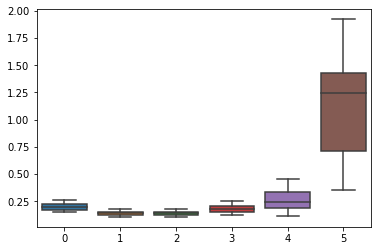

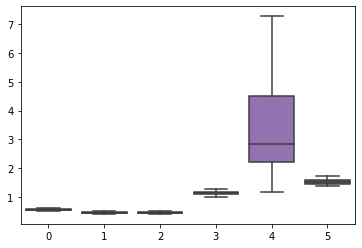

In [212]:
i = 0
data = np.array([Reg_RF.T[i], Reg_OLS.T[i], Reg_Ridge.T[i], Reg_ML.T[i], Reg_SPO.T[i], Reg_SVMOGD.T[i]]).T
np.savetxt(os.path.join('Sample_Complexity', f"Loss_N{N_train_set[i]}"), data)
sns.boxplot(data = data, showfliers = False)
plt.show()

data = np.array([Err_RF.T[i], Err_OLS.T[i], Err_Ridge.T[i], Err_ML.T[i], Err_SPO.T[i], Err_SVMOGD.T[i]]).T
np.savetxt(os.path.join('Sample_Complexity', f"Error_N{N_train_set[i]}"), data)
sns.boxplot(data = data, showfliers = False)
plt.show()

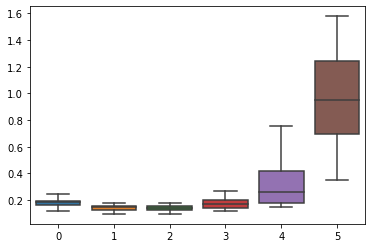

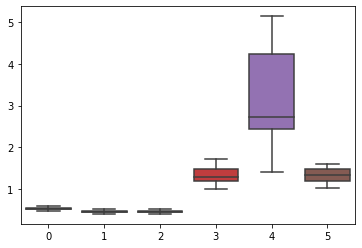

In [255]:
i = 1
data = np.array([Reg_RF.T[i], Reg_OLS.T[i], Reg_Ridge.T[i], Reg_ML.T[i], Reg_SPO.T[i], Reg_SVMOGD.T[i]]).T
np.savetxt(os.path.join('Sample_Complexity', f"Loss_N{N_train_set[i]}"), data)
sns.boxplot(data = data, showfliers = False)
plt.show()

data = np.array([Err_RF.T[i], Err_OLS.T[i], Err_Ridge.T[i], Err_ML.T[i], Err_SPO.T[i], Err_SVMOGD.T[i]]).T
np.savetxt(os.path.join('Sample_Complexity', f"Error_N{N_train_set[i]}"), data)
sns.boxplot(data = data, showfliers = False)
plt.show()

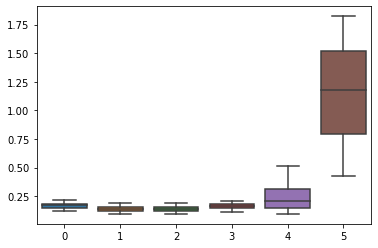

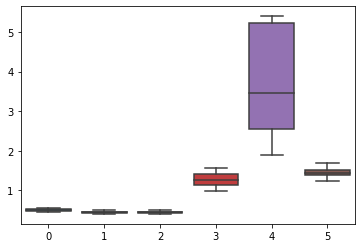

In [334]:
i = 2
data = np.array([Reg_RF.T[i], Reg_OLS.T[i], Reg_Ridge.T[i], Reg_ML.T[i], Reg_SPO.T[i], Reg_SVMOGD.T[i]]).T
np.savetxt(os.path.join('Sample_Complexity', f"Loss_N{N_train_set[i]}"), data)
sns.boxplot(data = data, showfliers = False)
plt.show()

data = np.array([Err_RF.T[i], Err_OLS.T[i], Err_Ridge.T[i], Err_ML.T[i], Err_SPO.T[i], Err_SVMOGD.T[i]]).T
np.savetxt(os.path.join('Sample_Complexity', f"Error_N{N_train_set[i]}"), data)
sns.boxplot(data = data, showfliers = False)
plt.show()

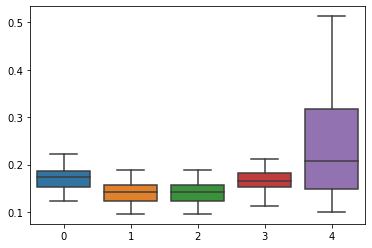

In [341]:
data = np.loadtxt(os.path.join('Sample_Complexity', 'Loss_N500'))
data = data[:, :-1]
sns.boxplot(data = data, showfliers = False)
plt.show()

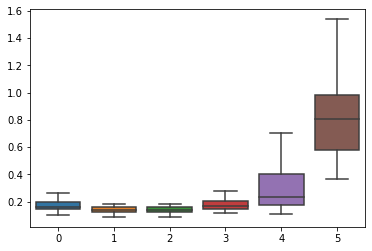

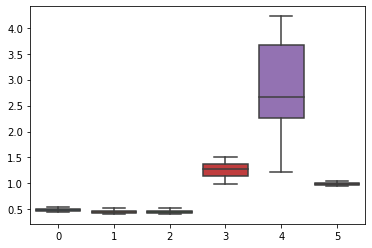

In [314]:
i = 3
data = np.array([Reg_RF.T[i], Reg_OLS.T[i], Reg_Ridge.T[i], Reg_ML.T[i], Reg_SPO.T[i], Reg_SVMOGD.T[i]]).T
np.savetxt(os.path.join('Sample_Complexity', f"Loss_N{N_train_set[i]}"), data)
sns.boxplot(data = data, showfliers = False)
plt.show()

data = np.array([Err_RF.T[i], Err_OLS.T[i], Err_Ridge.T[i], Err_ML.T[i], Err_SPO.T[i], Err_SVMOGD.T[i]]).T
np.savetxt(os.path.join('Sample_Complexity', f"Error_N{N_train_set[i]}"), data)
sns.boxplot(data = data, showfliers = False)
plt.show()

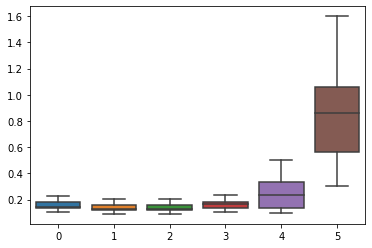

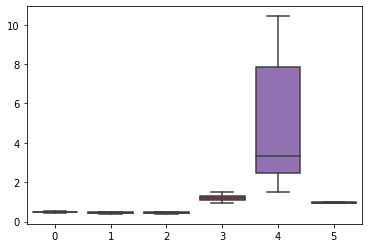

In [288]:
i = 4
data = np.array([Reg_RF.T[i], Reg_OLS.T[i], Reg_Ridge.T[i], Reg_ML.T[i], Reg_SPO.T[i], Reg_SVMOGD.T[i]]).T
np.savetxt(os.path.join('Sample_Complexity', f"Loss_N{N_train_set[i]}"), data)
sns.boxplot(data = data, showfliers = False)
plt.show()

data = np.array([Err_RF.T[i], Err_OLS.T[i], Err_Ridge.T[i], Err_ML.T[i], Err_SPO.T[i], Err_SVMOGD.T[i]]).T
np.savetxt(os.path.join('Sample_Complexity', f"Error_N{N_train_set[i]}"), data)
sns.boxplot(data = data, showfliers = False)
plt.show()

In [23]:
for trial in range(total_trial):
    # Generate Fractional Knapsack Samples
    benchmark = 1
    dim_features = 5
    dim_decision = 10
    price = np.random.randint(low=1, high=1000, size=dim_decision)
    lower = np.amax(price)
    upper = (np.random.rand()-1)*lower + np.sum(price)
    Budget = [(upper-lower)*np.random.rand() + lower]
    Coeff_Mat = np.random.binomial(n=1, p=0.5, size = (dim_decision, dim_features))
    Theta_true = -np.concatenate((Coeff_Mat, np.zeros((dim_decision+1, dim_features))), axis=0)
    print("*********************************************************")
    print("Trial", trial + 1)
    
    N_train = 1000
    # N_valid = 200
    N_test = 1000
    degree = 1
    additive_noise = 1.0
    scale_noise_uni = 0.0
    scale_noise_div = 0.1
    attack_threshold = None
    attack_power = 0.0
    z_train, c_train, A_train, b_train = dg.GenerateFractionalKnapsack(N_samples=N_train, dim_features=dim_features, dim_decision=dim_decision, Coeff_Mat=Coeff_Mat, price=price, Budget=Budget,
                                        degree=degree, additive_noise=additive_noise, scale_noise_uni=scale_noise_uni, scale_noise_div=scale_noise_div, attack_threshold = attack_threshold, attack_power = attack_power)
    # z_valid, c_valid, A_valid, b_valid = dg.GenerateFractionalKnapsack(N_samples=N_valid, dim_features=dim_features, dim_decision=dim_decision, Coeff_Mat=Coeff_Mat, price=price, Budget=Budget,
    #                                     degree=degree, additive_noise=additive_noise, scale_noise_uni=scale_noise_uni, scale_noise_div=scale_noise_div, attack_threshold = attack_threshold, attack_power = attack_power)
    z_test, c_test, A_test, b_test = dg.GenerateFractionalKnapsack(N_samples=N_test, dim_features=dim_features, dim_decision=dim_decision, Coeff_Mat=Coeff_Mat, price=price, Budget=Budget,
                                        degree=degree, additive_noise=additive_noise, scale_noise_uni=scale_noise_uni, scale_noise_div=scale_noise_div, attack_threshold = attack_threshold, attack_power = attack_power)
    # Compute Optimal Solutions
    start = time.time()
    basic_train, nonb_train, solution_train = lpm.ComputeBasis(c=c_train, A=A_train, b=b_train)
    #basic_valid, nonb_valid, solution_valid = lpm.ComputeBasis(c=c_valid, A=A_valid, b=b_valid)
    basic_test, nonb_test, solution_test = lpm.ComputeBasis(c=c_test, A=A_test, b=b_test)
    print("Time cost", time.time() - start)
    alg = 'SVMOGD'
    print("Method SVM OGD")
    print("Training samples", N_train)
    start = time.time()
    globals()["Theta_"+alg] = lm.SVM_OGD(A = A_train, b = b_train, z = z_train, basic = basic_train, nonb = nonb_train,
                                         step_size = 1e-2, radius = 1.1* np.linalg.norm(Coeff_Mat, 'f'), regular_const=1e-2)
    globals()["time_"+alg] = time.time() - start
    print("Time Cost", globals()["time_"+alg])
    globals()["loss_"+alg], globals()["error_"+alg], globals()["norm_err_"+alg] = lpm.ComputeLoss(benchmark = benchmark,A = A_test, b = b_test, c = c_test, z = z_test, direct = False,
                                                                                                    Theta = globals()["Theta_"+alg], solved = True, solution = solution_test)
    print("Loss", np.average(globals()["loss_"+alg]), "Error", np.average(globals()["error_"+alg]), "Normalized Error", np.average(globals()["norm_err_"+alg]))
    mark = 0
    for j in range(len(globals()[focus + "_set"])):
        if globals()[focus] == globals()[focus + "_set"][j]:
            mark = j
    globals()["Loss_" + alg][trial][mark] = np.average(globals()["loss_" + alg])
    globals()["Error_" + alg][trial][mark] = np.average(globals()["error_" + alg])
    globals()["Norm_Err_" + alg][trial][mark] = np.average(globals()["norm_err_" + alg])

*********************************************************
Trial 1
Time cost 3.6999521255493164
Method SVM OGD
Training samples 1000
Time Cost 0.06500387191772461
Loss 1.0836694526116781 Error 1.0859294662152639 Normalized Error 1.2053681412648827
*********************************************************
Trial 2
Time cost 3.4948089122772217
Method SVM OGD
Training samples 1000
Time Cost 0.06355476379394531
Loss 1.333529194882512 Error 1.1139861226262462 Normalized Error 1.2817227296040534
*********************************************************
Trial 3
Time cost 3.4894750118255615
Method SVM OGD
Training samples 1000
Time Cost 0.06600213050842285
Loss 0.3224817722222044 Error 0.968624193690609 Normalized Error 1.1966951492979678
*********************************************************
Trial 4
Time cost 3.551055431365967
Method SVM OGD
Training samples 1000
Time Cost 0.06404566764831543
Loss 1.1145710659641723 Error 1.146740841065964 Normalized Error 1.2475662809536079
****************

KeyboardInterrupt: 

In [22]:
print(np.average(globals()["Loss_" + alg][trial][mark]))

0.944507443916253


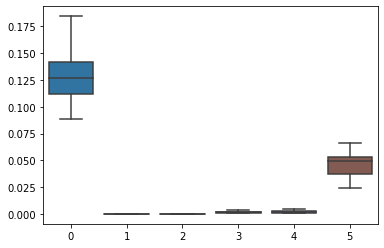

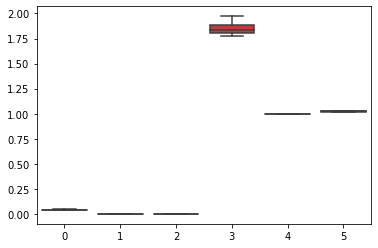

In [121]:
i = 0
data = np.array([Reg_RF.T[i], Reg_OLS.T[i], Reg_Ridge.T[i], Reg_ML.T[i], Reg_SPO.T[i], Reg_SVMOGD.T[i]]).T
np.savetxt(os.path.join('Degree', f"Loss_degree{degree_set[i]}"), data)
sns.boxplot(data = data, showfliers = False)
plt.show()

data = np.array([Err_RF.T[i], Err_OLS.T[i], Err_Ridge.T[i], Err_ML.T[i], Err_SPO.T[i], Err_SVMOGD.T[i]]).T
np.savetxt(os.path.join('Degree', f"Error_degree{degree_set[i]}"), data)
sns.boxplot(data = data, showfliers = False)
plt.show()

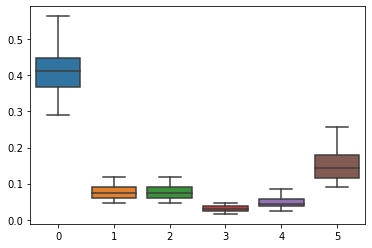

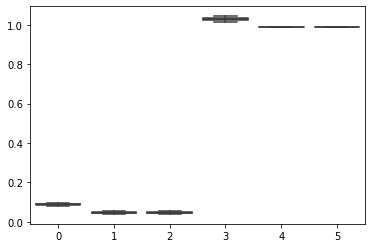

In [122]:
i = 1
data = np.array([Reg_RF.T[i], Reg_OLS.T[i], Reg_Ridge.T[i], Reg_ML.T[i], Reg_SPO.T[i], Reg_SVMOGD.T[i]]).T
np.savetxt(os.path.join('Degree', f"Loss_degree{degree_set[i]}"), data)
sns.boxplot(data = data, showfliers = False)
plt.show()

data = np.array([Err_RF.T[i], Err_OLS.T[i], Err_Ridge.T[i], Err_ML.T[i], Err_SPO.T[i], Err_SVMOGD.T[i]]).T
np.savetxt(os.path.join('Degree', f"Error_degree{degree_set[i]}"), data)
sns.boxplot(data = data, showfliers = False)
plt.show()

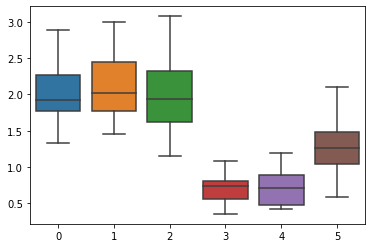

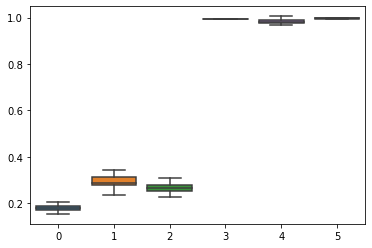

In [123]:
i = 2
data = np.array([Reg_RF.T[i], Reg_OLS.T[i], Reg_Ridge.T[i], Reg_ML.T[i], Reg_SPO.T[i], Reg_SVMOGD.T[i]]).T
np.savetxt(os.path.join('Degree', f"Loss_degree{degree_set[i]}"), data)
sns.boxplot(data = data, showfliers = False)
plt.show()

data = np.array([Err_RF.T[i], Err_OLS.T[i], Err_Ridge.T[i], Err_ML.T[i], Err_SPO.T[i], Err_SVMOGD.T[i]]).T
np.savetxt(os.path.join('Degree', f"Error_degree{degree_set[i]}"), data)
sns.boxplot(data = data, showfliers = False)
plt.show()

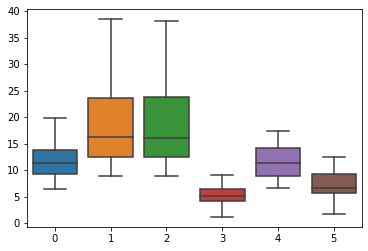

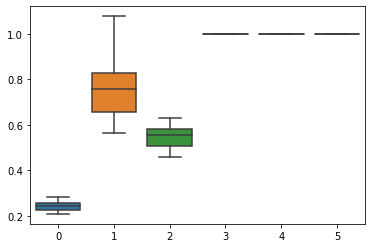

In [125]:
i = 3
data = np.array([Reg_RF.T[i], Reg_OLS.T[i], Reg_Ridge.T[i], Reg_ML.T[i], Reg_SPO.T[i], Reg_SVMOGD.T[i]]).T
np.savetxt(os.path.join('Degree', f"Loss_degree{degree_set[i]}"), data)
sns.boxplot(data = data, showfliers = False)
plt.show()

data = np.array([Err_RF.T[i], Err_OLS.T[i], Err_Ridge.T[i], Err_ML.T[i], Err_SPO.T[i], Err_SVMOGD.T[i]]).T
np.savetxt(os.path.join('Degree', f"Error_degree{degree_set[i]}"), data)
sns.boxplot(data = data, showfliers = False)
plt.show()

In [161]:
np.savetxt(os.path.join('Sample_Complexity', "RegretSP_N"), [Reg_RF[0], Reg_ML[0], Reg_Ridge[0], Reg_OLS[0], Reg_SPO[0], Reg_NOGD[0], Reg_SVMOGD[0]])
np.savetxt(os.path.join('Sample_Complexity', "ErrorSP_N"), [Err_RF[0], Err_ML[0], Err_Ridge[0], Err_OLS[0], Err_SPO[0], Err_NOGD[0], Err_SVMOGD[0]])

In [137]:
N_set = [100, 200, 500, 1000, 2000, 5000]
for N in N_set:
    [globals()[f"Regret_RF_{N}"], globals()[f"Regret_ML_{N}"], globals()[f"Regret_Ridge_{N}"],
     globals()[f"Regret_OLS_{N}"], globals()[f"Regret_SPO_{N}"], globals()[f"Regret_NOGD_{N}"], 
     globals()[f"Regret_SVMOGD_{N}"]] = np.loadtxt(os.path.join('Sample_Complexity', "RegretFK_N{}".format(N)))
    [globals()[f"Error_RF_{N}"], globals()[f"Error_ML_{N}"], globals()[f"Error_Ridge_{N}"],
     globals()[f"Error_OLS_{N}"], globals()[f"Error_SPO_{N}"], globals()[f"Error_NOGD_{N}"],
     globals()[f"Error_SVMOGD_{N}"]] = np.loadtxt(os.path.join('Sample_Complexity', "ErrorFK_N{}".format(N)))


In [140]:
regret = []
error = []
columns = []
for N in N_set:
    regret = regret + [globals()[f"Regret_RF_{N}"], globals()[f"Regret_Ridge_{N}"], globals()[f"Regret_OLS_{N}"],
                              globals()[f"Regret_ML_{N}"], globals()[f"Regret_SPO_{N}"], globals()[f"Regret_NOGD_{N}"], 
                              globals()[f"Regret_SVMOGD_{N}"]]
    error = error + [globals()[f"Error_RF_{N}"], globals()[f"Error_Ridge_{N}"], globals()[f"Error_OLS_{N}"],
                              globals()[f"Error_ML_{N}"], globals()[f"Error_SPO_{N}"], globals()[f"Error_NOGD_{N}"], 
                              globals()[f"Error_SVMOGD_{N}"]]
    columns = columns + [f"RF, {N}", f"Ridge, {N}", f"OLS, {N}", f"ML, {N}", f"SPO, {N}", f"NOGD, {N}", f"SVMOGD, {N}"]
data_reg = pd.DataFrame(np.array(regret).T, columns = columns)
data_err = pd.DataFrame(np.array(error).T, columns = columns)

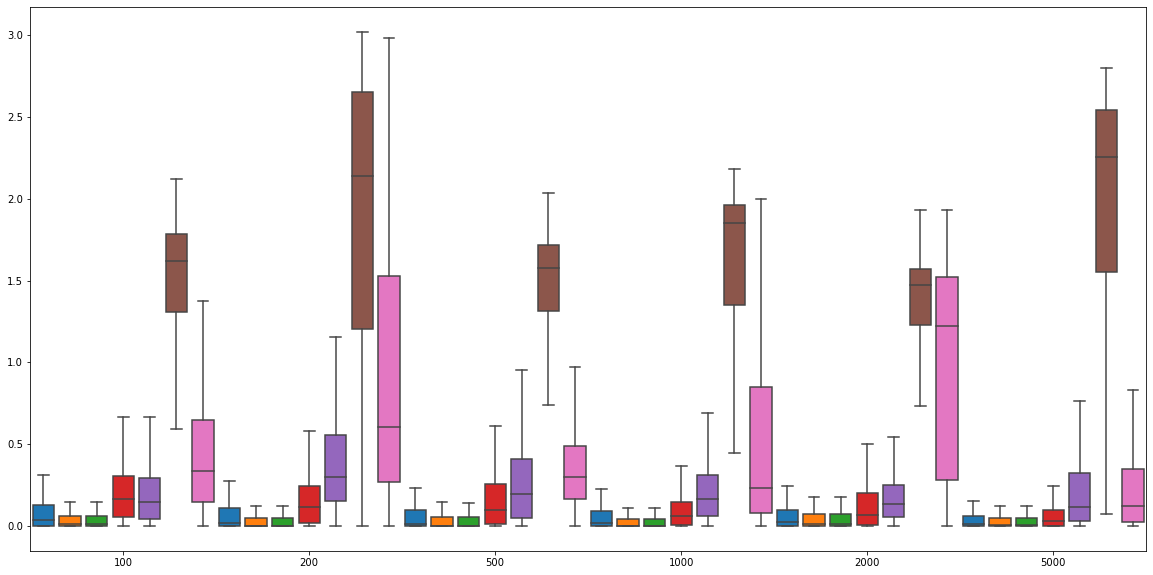

In [143]:
methods = ['RF', 'Ridge', 'OLS', 'ML', 'SPO', 'NOGD', 'SVMOGD']
fig, ax = plt.subplots(figsize=(20, 10))
ax = sns.boxplot(data=data_reg, showfliers=False)
xticks = []
xticklabels = []
for i in range(len(N_set)):
    xticks.append(int(len(methods)/2) + i * len(methods))
    xticklabels.append(f'{N_set[i]}')
plt.setp(ax, xticks=xticks, xticklabels=xticklabels)
boxes = ax.artists

for i,box in enumerate(boxes):
    for j in range(len(methods)):
        if methods[j] in data_reg.columns[i]:
            box.set_facecolor(sns.color_palette()[j])

plt.show()

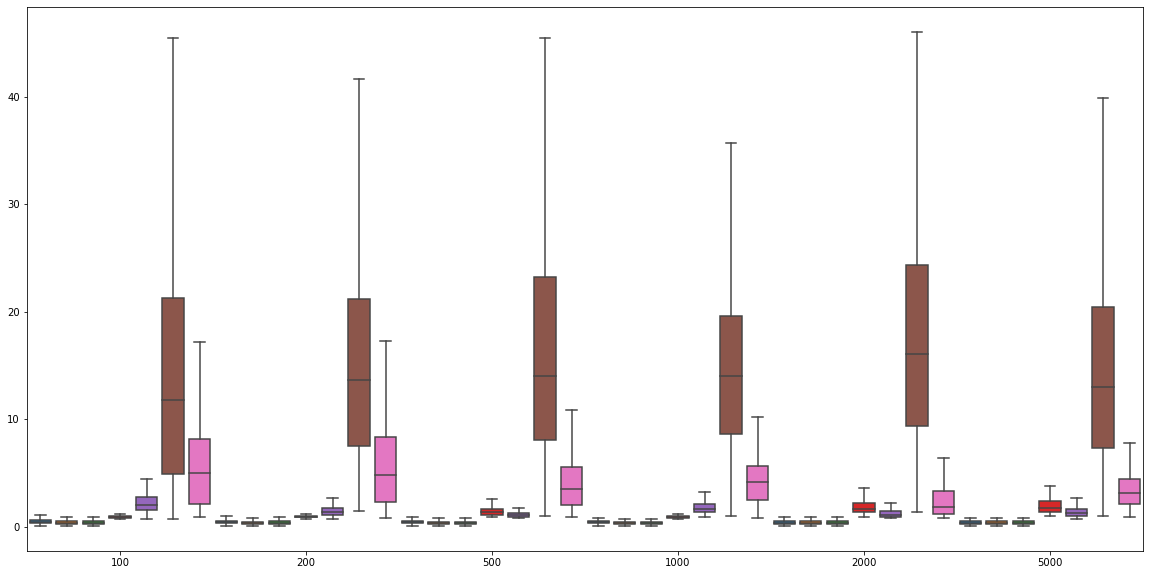

In [144]:
fig, ax = plt.subplots(figsize=(20, 10))
ax = sns.boxplot(data=data_err, showfliers=False)
plt.setp(ax, xticks=xticks, xticklabels=xticklabels)
boxes = ax.artists

methods = ['RF', 'Ridge', 'OLS', 'ML', 'SPO', 'NOGD', 'SVMOGD']
for i,box in enumerate(boxes):
    for j in range(len(methods)):
        if methods[j] in data_reg.columns[i]:
            box.set_facecolor(sns.color_palette()[j])

plt.show()

In [250]:
dim_set = [6, 8, 10, 12, 14]
for dim in dim_set:
    [globals()[f"Regret_RF_{dim}"], globals()[f"Regret_ML_{dim}"], globals()[f"Regret_Ridge_{dim}"],
     globals()[f"Regret_OLS_{dim}"], globals()[f"Regret_SPO_{dim}"], globals()[f"Regret_NOGD_{dim}"], 
     globals()[f"Regret_SVMOGD_{dim}"]] = np.loadtxt(os.path.join('Problem_Size', "RegretFK_dim{}".format(dim)))
    [globals()[f"Error_RF_{dim}"], globals()[f"Error_ML_{dim}"], globals()[f"Error_Ridge_{dim}"],
     globals()[f"Error_OLS_{dim}"], globals()[f"Error_SPO_{dim}"], globals()[f"Error_NOGD_{dim}"],
     globals()[f"Error_SVMOGD_{dim}"]] = np.loadtxt(os.path.join('Problem_Size', "ErrorFK_dim{}".format(dim)))


In [253]:
regret = []
error = []
columns = []
for dim in dim_set:
    regret = regret + [globals()[f"Regret_RF_{dim}"], globals()[f"Regret_Ridge_{dim}"],
                 globals()[f"Regret_OLS_{dim}"], globals()[f"Regret_ML_{dim}"], globals()[f"Regret_SPO_{dim}"], globals()[f"Regret_NOGD_{dim}"], 
                 globals()[f"Regret_SVMOGD_{dim}"]]
    error = error + [globals()[f"Error_RF_{dim}"], globals()[f"Error_Ridge_{dim}"],
                 globals()[f"Error_OLS_{dim}"], globals()[f"Error_ML_{dim}"], globals()[f"Error_SPO_{dim}"], globals()[f"Error_NOGD_{dim}"],
                 globals()[f"Error_SVMOGD_{dim}"]]
    columns = columns + [f"RF, {dim}", f"Ridge, {dim}", f"OLS, {dim}", f"ML, {dim}", f"SPO, {dim}", f"NOGD, {dim}", f"SVMOGD, {dim}"]
data_reg = pd.DataFrame(np.array(regret).T, columns = columns)
data_err = pd.DataFrame(np.array(error).T, columns = columns)

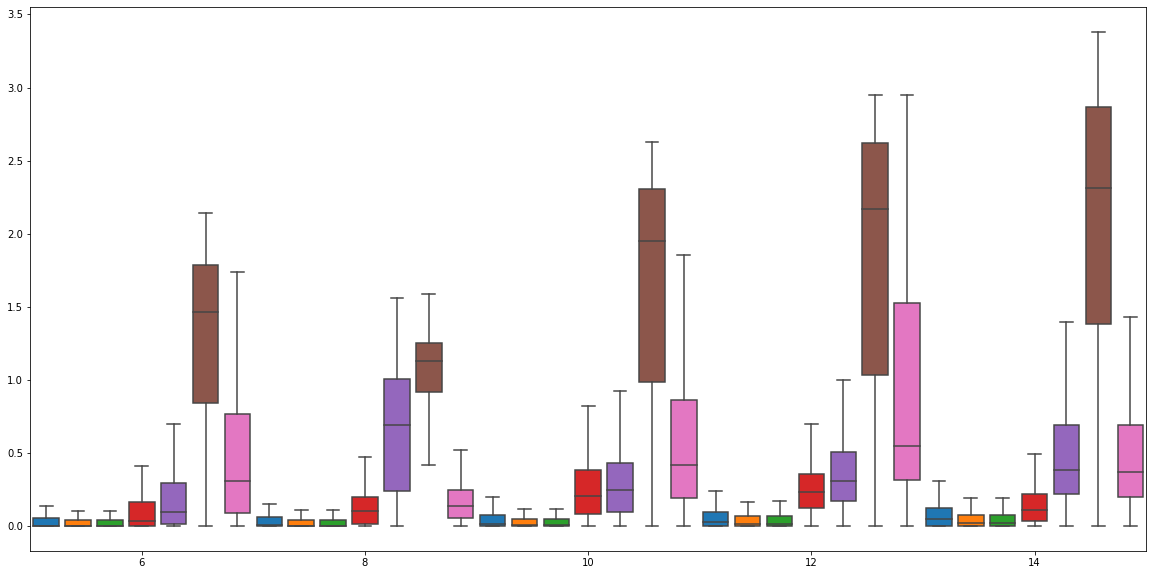

In [254]:
methods = ['RF', 'Ridge', 'OLS', 'ML', 'SPO', 'NOGD', 'SVMOGD']
fig, ax = plt.subplots(figsize=(20, 10))
ax = sns.boxplot(data=data_reg, showfliers=False)
xticks = []
xticklabels = []
for i in range(len(dim_set)):
    xticks.append(int(len(methods)/2) + i * len(methods))
    xticklabels.append(f'{dim_set[i]}')
plt.setp(ax, xticks=xticks, xticklabels=xticklabels)
boxes = ax.artists

for i,box in enumerate(boxes):
    for j in range(len(methods)):
        if methods[j] in data_reg.columns[i]:
            box.set_facecolor(sns.color_palette()[j])

plt.show()

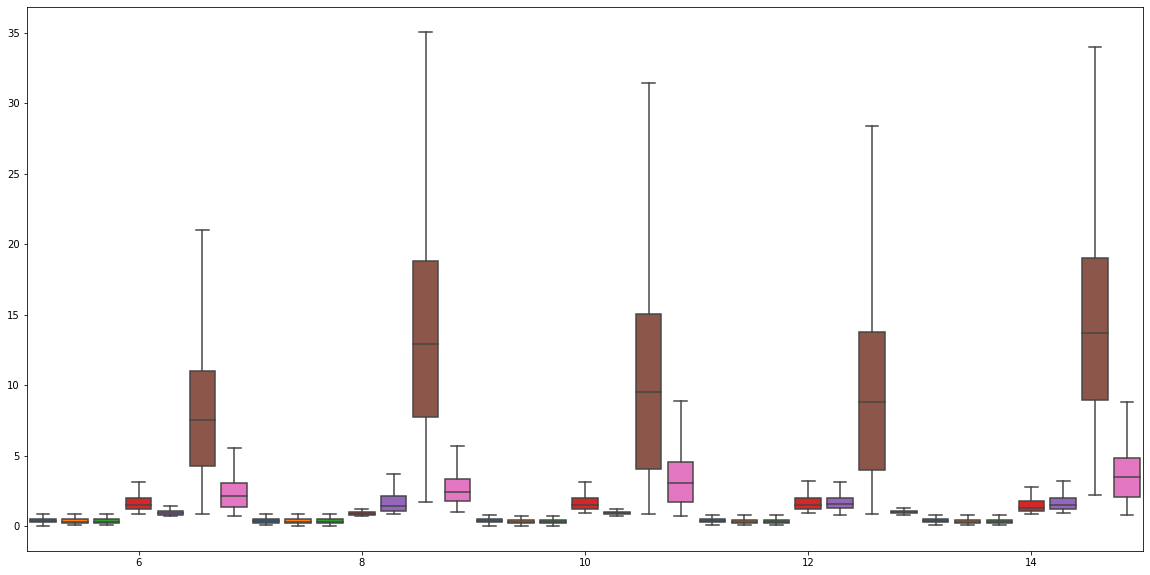

In [255]:
fig, ax = plt.subplots(figsize=(20, 10))
ax = sns.boxplot(data=data_err, showfliers=False)
plt.setp(ax, xticks=xticks, xticklabels=xticklabels)
boxes = ax.artists

methods = ['RF', 'Ridge', 'OLS', 'ML', 'SPO', 'NOGD', 'SVMOGD']
for i,box in enumerate(boxes):
    for j in range(len(methods)):
        if methods[j] in data_reg.columns[i]:
            box.set_facecolor(sns.color_palette()[j])

plt.show()

In [390]:
AN_set = [0.1, 0.3, 0.5, 0.7, 0.9]
for an in AN_set:
    [globals()[f"Regret_RF_{an}"], globals()[f"Regret_ML_{an}"], globals()[f"Regret_Ridge_{an}"],
     globals()[f"Regret_OLS_{an}"], globals()[f"Regret_SPO_{an}"], globals()[f"Regret_NOGD_{an}"], 
     globals()[f"Regret_SVMOGD_{an}"]] = np.loadtxt(os.path.join('Additive_Noise', "RegretFK_AN{}".format(an)))
    [globals()[f"Error_RF_{an}"], globals()[f"Error_ML_{an}"], globals()[f"Error_Ridge_{an}"],
     globals()[f"Error_OLS_{an}"], globals()[f"Error_SPO_{an}"], globals()[f"Error_NOGD_{an}"],
     globals()[f"Error_SVMOGD_{an}"]] = np.loadtxt(os.path.join('Additive_Noise', "ErrorFK_AN{}".format(an)))


In [391]:
regret = []
error = []
columns = []
for an in AN_set:
    regret = regret + [globals()[f"Regret_RF_{an}"], globals()[f"Regret_Ridge_{an}"],
                 globals()[f"Regret_OLS_{an}"], globals()[f"Regret_ML_{an}"], globals()[f"Regret_SPO_{an}"], globals()[f"Regret_NOGD_{an}"], 
                 globals()[f"Regret_SVMOGD_{an}"]]
    error = error + [globals()[f"Error_RF_{an}"], globals()[f"Error_Ridge_{an}"],
                 globals()[f"Error_OLS_{an}"], globals()[f"Error_ML_{an}"], globals()[f"Error_SPO_{an}"], globals()[f"Error_NOGD_{an}"],
                 globals()[f"Error_SVMOGD_{an}"]]
    columns = columns + [f"RF, {an}", f"Ridge, {an}", f"OLS, {an}", f"ML, {an}", f"SPO, {an}", f"NOGD, {an}", f"SVMOGD, {an}"]
data_reg = pd.DataFrame(np.array(regret).T, columns = columns)
data_err = pd.DataFrame(np.array(error).T, columns = columns)

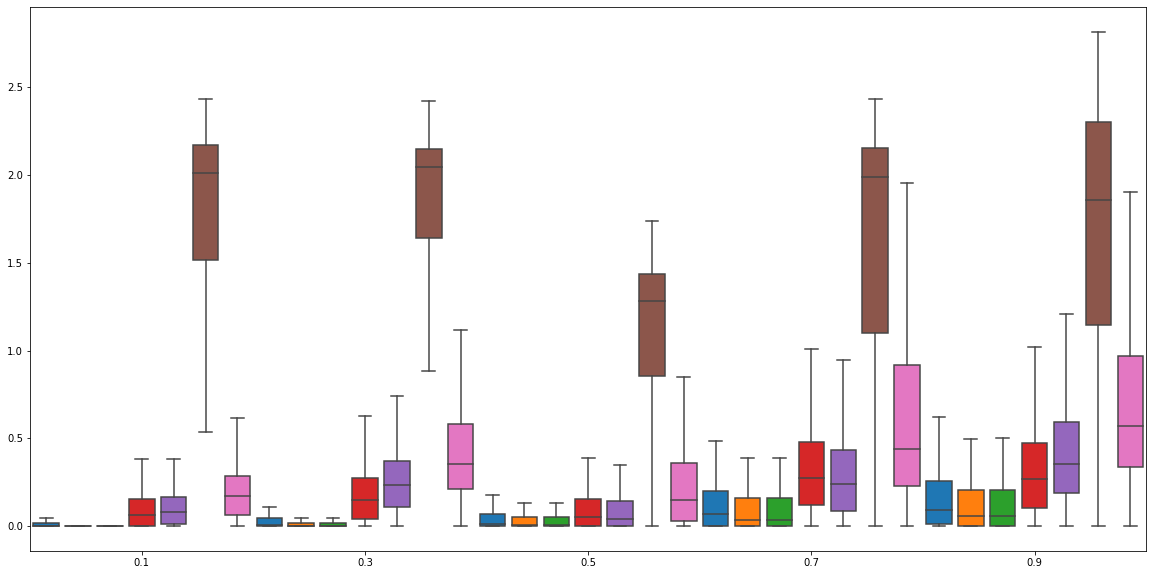

In [392]:
methods = ['RF', 'Ridge', 'OLS', 'ML', 'SPO', 'NOGD', 'SVMOGD']
fig, ax = plt.subplots(figsize=(20, 10))
ax = sns.boxplot(data=data_reg, showfliers=False)
xticks = []
xticklabels = []
for i in range(len(AN_set)):
    xticks.append(int(len(methods)/2) + i * len(methods))
    xticklabels.append(f'{AN_set[i]}')
plt.setp(ax, xticks=xticks, xticklabels=xticklabels)
boxes = ax.artists

for i,box in enumerate(boxes):
    for j in range(len(methods)):
        if methods[j] in data_reg.columns[i]:
            box.set_facecolor(sns.color_palette()[j])

plt.show()

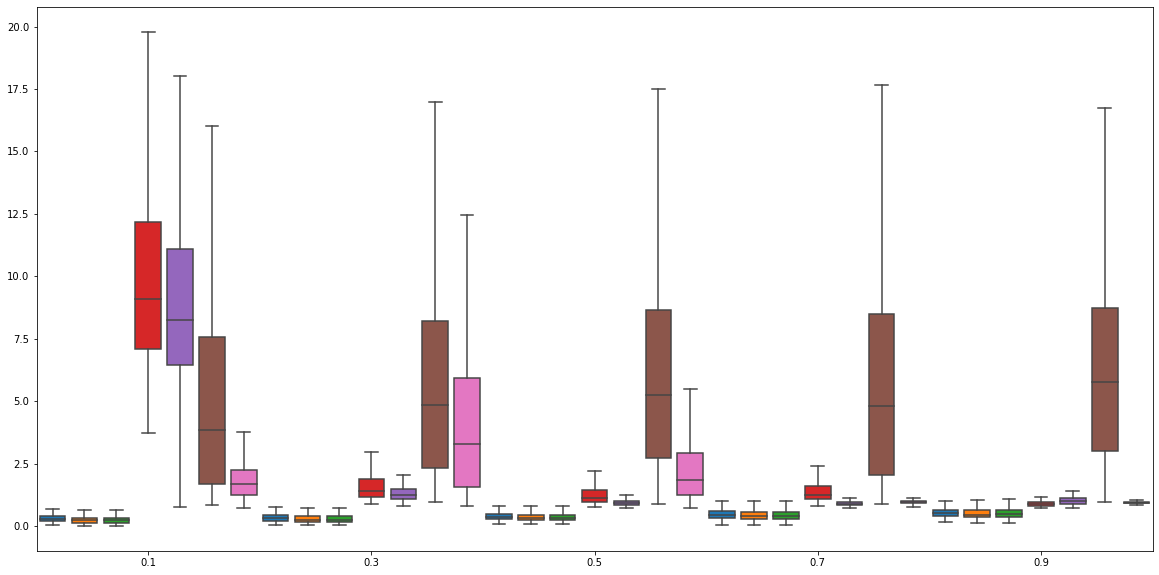

In [393]:
fig, ax = plt.subplots(figsize=(20, 10))
ax = sns.boxplot(data=data_err, showfliers=False)
plt.setp(ax, xticks=xticks, xticklabels=xticklabels)
boxes = ax.artists

methods = ['RF', 'Ridge', 'OLS', 'ML', 'SPO', 'NOGD', 'SVMOGD']
for i,box in enumerate(boxes):
    for j in range(len(methods)):
        if methods[j] in data_reg.columns[i]:
            box.set_facecolor(sns.color_palette()[j])

plt.show()

In [500]:
SN_set = [0.1, 0.3, 0.5, 0.7, 0.9]
for sn in SN_set:
    [globals()[f"Regret_RF_{sn}"], globals()[f"Regret_ML_{sn}"], globals()[f"Regret_Ridge_{sn}"],
     globals()[f"Regret_OLS_{sn}"], globals()[f"Regret_SPO_{sn}"], globals()[f"Regret_NOGD_{sn}"], 
     globals()[f"Regret_SVMOGD_{sn}"]] = np.loadtxt(os.path.join('Scalar_Noise', "RegretFK_SN{}".format(sn)))
    [globals()[f"Error_RF_{sn}"], globals()[f"Error_ML_{sn}"], globals()[f"Error_Ridge_{sn}"],
     globals()[f"Error_OLS_{sn}"], globals()[f"Error_SPO_{sn}"], globals()[f"Error_NOGD_{sn}"],
     globals()[f"Error_SVMOGD_{sn}"]] = np.loadtxt(os.path.join('Scalar_Noise', "ErrorFK_SN{}".format(sn)))


In [501]:
regret = []
error = []
columns = []
for sn in SN_set:
    regret = regret + [globals()[f"Regret_RF_{sn}"], globals()[f"Regret_Ridge_{sn}"],
                 globals()[f"Regret_OLS_{sn}"], globals()[f"Regret_ML_{sn}"], globals()[f"Regret_SPO_{sn}"], globals()[f"Regret_NOGD_{sn}"], 
                 globals()[f"Regret_SVMOGD_{sn}"]]
    error = error + [globals()[f"Error_RF_{sn}"], globals()[f"Error_Ridge_{sn}"],
                 globals()[f"Error_OLS_{sn}"], globals()[f"Error_ML_{sn}"], globals()[f"Error_SPO_{sn}"], globals()[f"Error_NOGD_{sn}"],
                 globals()[f"Error_SVMOGD_{sn}"]]
    columns = columns + [f"RF, {sn}", f"Ridge, {sn}", f"OLS, {sn}", f"ML, {sn}", f"SPO, {sn}", f"NOGD, {sn}", f"SVMOGD, {sn}"]
data_reg = pd.DataFrame(np.array(regret).T, columns = columns)
data_err = pd.DataFrame(np.array(error).T, columns = columns)

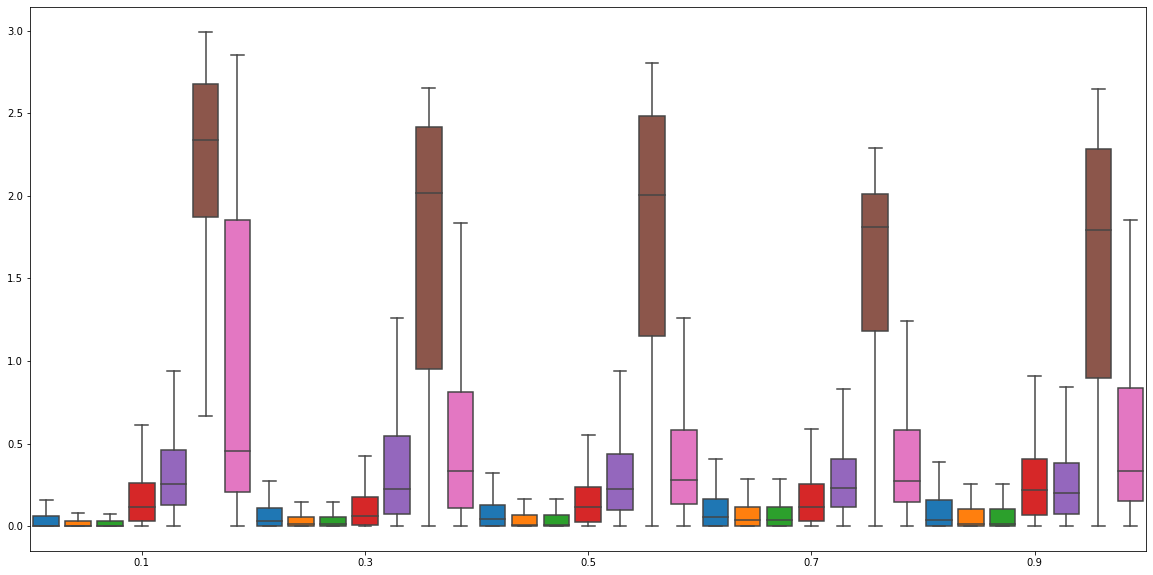

In [502]:
methods = ['RF', 'Ridge', 'OLS', 'ML', 'SPO', 'NOGD', 'SVMOGD']
fig, ax = plt.subplots(figsize=(20, 10))
ax = sns.boxplot(data=data_reg, showfliers=False)
xticks = []
xticklabels = []
for i in range(len(SN_set)):
    xticks.append(int(len(methods)/2) + i * len(methods))
    xticklabels.append(f'{SN_set[i]}')
plt.setp(ax, xticks=xticks, xticklabels=xticklabels)
boxes = ax.artists

for i,box in enumerate(boxes):
    for j in range(len(methods)):
        if methods[j] in data_reg.columns[i]:
            box.set_facecolor(sns.color_palette()[j])

plt.show()

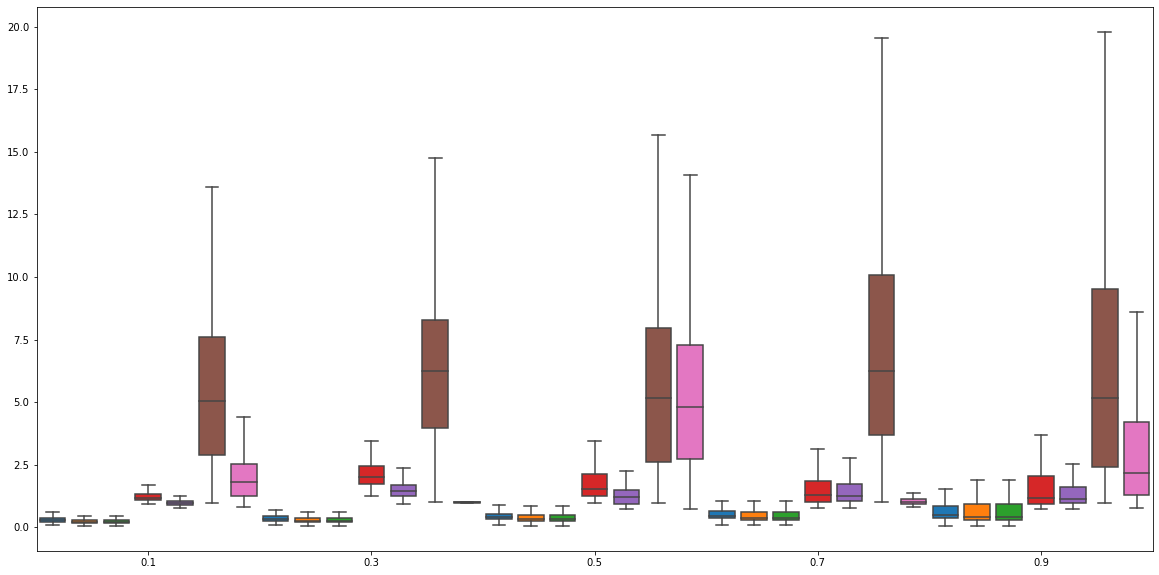

In [503]:
fig, ax = plt.subplots(figsize=(20, 10))
ax = sns.boxplot(data=data_err, showfliers=False)
plt.setp(ax, xticks=xticks, xticklabels=xticklabels)
boxes = ax.artists

methods = ['RF', 'Ridge', 'OLS', 'ML', 'SPO', 'NOGD', 'SVMOGD']
for i,box in enumerate(boxes):
    for j in range(len(methods)):
        if methods[j] in data_reg.columns[i]:
            box.set_facecolor(sns.color_palette()[j])

plt.show()

In [7]:
degree_set = [1, 3, 5, 7]
for deg in degree_set:
    [globals()[f"Regret_RF_{deg}"], globals()[f"Regret_ML_{deg}"], globals()[f"Regret_Ridge_{deg}"],
     globals()[f"Regret_OLS_{deg}"], globals()[f"Regret_SPO_{deg}"], globals()[f"Regret_NOGD_{deg}"], 
     globals()[f"Regret_SVMOGD_{deg}"]] = np.loadtxt(os.path.join('Degree', "RegretFK_deg{}".format(deg)))
    [globals()[f"Error_RF_{deg}"], globals()[f"Error_ML_{deg}"], globals()[f"Error_Ridge_{deg}"],
     globals()[f"Error_OLS_{deg}"], globals()[f"Error_SPO_{deg}"], globals()[f"Error_NOGD_{deg}"],
     globals()[f"Error_SVMOGD_{deg}"]] = np.loadtxt(os.path.join('Degree', "ErrorFK_deg{}".format(deg)))


In [8]:
regret = []
error = []
columns = []
for deg in degree_set:
    regret = regret + [globals()[f"Regret_RF_{deg}"], globals()[f"Regret_Ridge_{deg}"],
             globals()[f"Regret_OLS_{deg}"], globals()[f"Regret_ML_{deg}"], globals()[f"Regret_SPO_{deg}"], globals()[f"Regret_NOGD_{deg}"], 
             globals()[f"Regret_SVMOGD_{deg}"]]
    error = error + [globals()[f"Error_RF_{deg}"], globals()[f"Error_Ridge_{deg}"],
             globals()[f"Error_OLS_{deg}"], globals()[f"Error_ML_{deg}"], globals()[f"Error_SPO_{deg}"], globals()[f"Error_NOGD_{deg}"],
             globals()[f"Error_SVMOGD_{deg}"]]
    columns = columns + [f"RF, {deg}", f"Ridge, {deg}", f"OLS, {deg}", f"ML, {deg}", f"SPO, {deg}", f"NOGD, {deg}", f"SVMOGD, {deg}"]
data_reg = pd.DataFrame(np.array(regret).T, columns = columns)
data_err = pd.DataFrame(np.array(error).T, columns = columns)

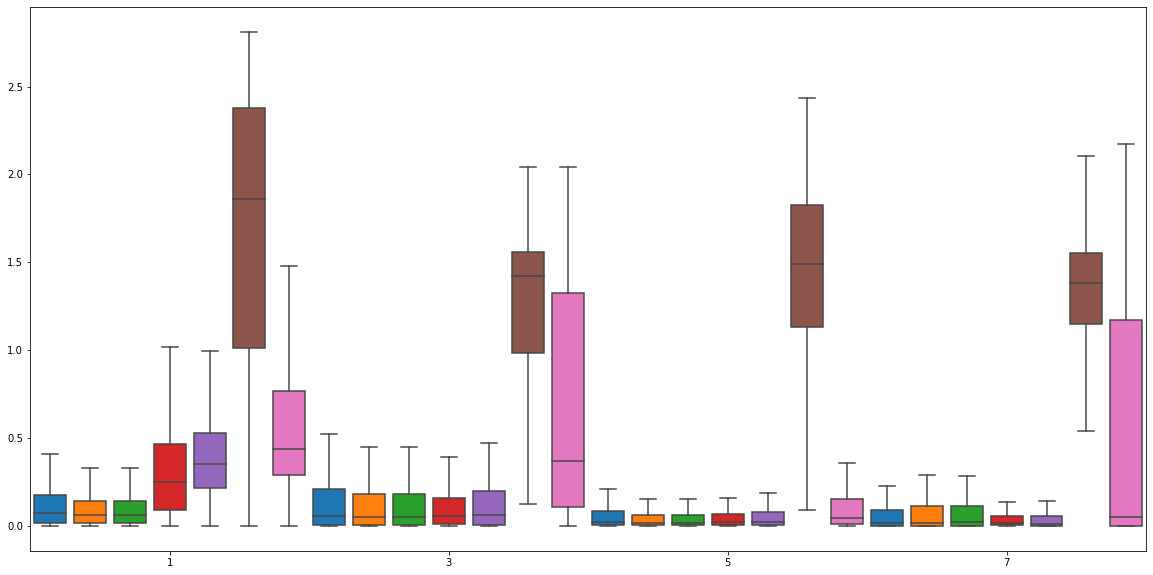

In [9]:
methods = ['RF', 'Ridge', 'OLS', 'ML', 'SPO', 'NOGD', 'SVMOGD']
fig, ax = plt.subplots(figsize=(20, 10))
ax = sns.boxplot(data=data_reg, showfliers=False)
xticks = []
xticklabels = []
for i in range(len(degree_set)):
    xticks.append(int(len(methods)/2) + i * len(methods))
    xticklabels.append(f'{degree_set[i]}')
plt.setp(ax, xticks=xticks, xticklabels=xticklabels)
boxes = ax.artists

for i,box in enumerate(boxes):
    for j in range(len(methods)):
        if methods[j] in data_reg.columns[i]:
            box.set_facecolor(sns.color_palette()[j])

plt.show()

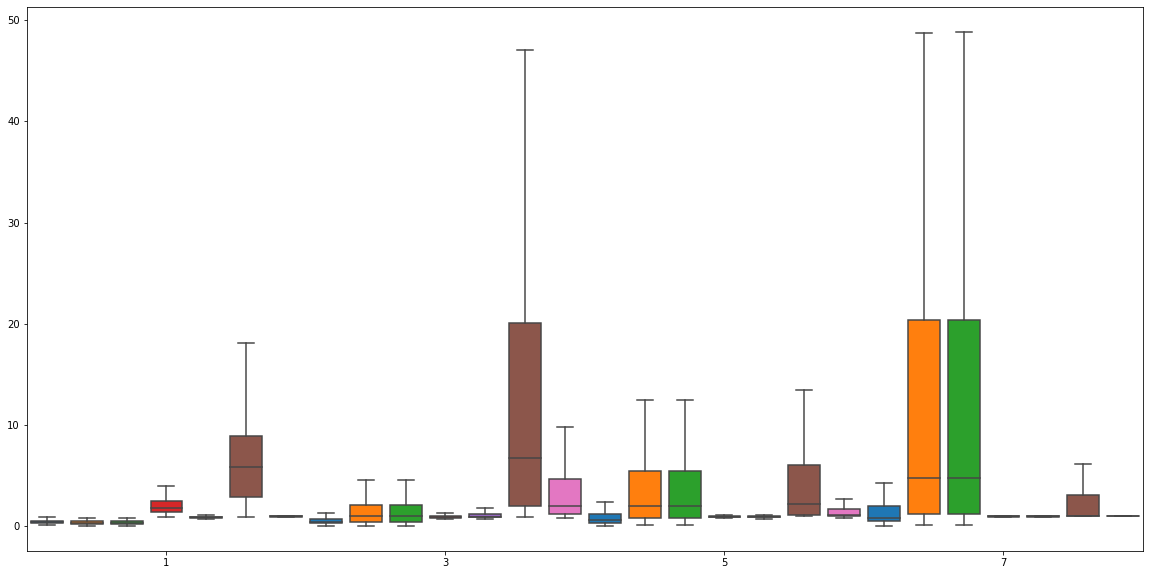

In [10]:
fig, ax = plt.subplots(figsize=(20, 10))
ax = sns.boxplot(data=data_err, showfliers=False)
plt.setp(ax, xticks=xticks, xticklabels=xticklabels)
boxes = ax.artists

methods = ['RF', 'Ridge', 'OLS', 'ML', 'SPO', 'NOGD', 'SVMOGD']
for i,box in enumerate(boxes):
    for j in range(len(methods)):
        if methods[j] in data_reg.columns[i]:
            box.set_facecolor(sns.color_palette()[j])

plt.show()

In [ ]:
import numpy as np
import cvxpy as cp
import sklearn
import sklearn.datasets
from sklearn.ensemble import RandomForestRegressor
import gurobipy
import mosek
import matplotlib.pyplot as plt
from multiprocessing import Pool
import time
import os
import seaborn as sns
import pandas as pd
# My Code
import LearningMethod as lm
import DataGeneration as dg
import LinearProgramMethod as lpm
import OnlineMethod as om

# Generate Fractional Knapsack Samples
benchmark = 1
dim_features = 5
dim_decision = 10
price = np.random.rand(dim_decision)
lower = np.amax(price)
upper = (np.random.rand()-1)*lower + np.sum(price)
Budget = [(upper-lower)*np.random.rand() + lower]
Coeff_Mat = np.random.binomial(n=1, p=0.5, size = (dim_decision, dim_features))
Theta_true = -np.concatenate((Coeff_Mat, np.zeros((dim_decision+1, dim_features))), axis=0)

N = 1000
z, c, A, b = dg.GenerateFractionalKnapsack_Margin(N_samples=N, dim_features=dim_features, dim_decision=dim_decision,
                                                  price=price, Budget=Budget, Coeff_Mat=Coeff_Mat, margin=0.00)

# Compute Optimal Solutions
start = time.time()
basic, nonb, solution = lpm.ComputeBasis(c=c, A=A, b=b)
print("Time cost", time.time() - start)

100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [26:31<00:00,  1.59s/it]


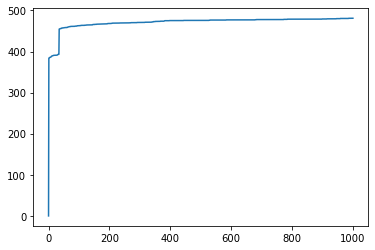

In [4]:
Regret_ML = om.OnlineMarginLearning(A=A, b=b, c=c, z=z, basic=basic, nonb=nonb,
                                    regular_const=1e-6, solved=True, solution=solution, show_figure=True, checkpoint = 1)

  2%|█▌                                                                             | 19/1000 [00:00<00:05, 184.10it/s]

Time cost 1.7151317596435547


  2%|█▌                                                                             | 19/1000 [00:00<00:05, 172.93it/s]

Time cost 1.711205005645752


  2%|█▎                                                                             | 17/1000 [00:00<00:05, 167.22it/s]

Time cost 1.7656826972961426


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [02:33<00:00,  6.53it/s]


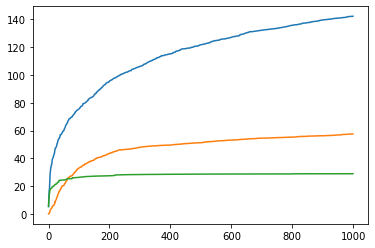

In [3]:
total_trials = 3
N = 1000
Regret_OGD = np.zeros(N)
Regret_MoM = np.zeros(N)
Regret_Perceptron = np.zeros(N)
for trial in range(total_trials):
    # Generate Fractional Knapsack Samples
    benchmark = 1
    dim_features = 5
    dim_decision = 10
    price = np.random.rand(dim_decision)
    lower = np.amax(price)
    upper = (np.random.rand()-1)*lower + np.sum(price)
    Budget = [(upper-lower)*np.random.rand() + lower]
    Coeff_Mat = np.random.binomial(n=1, p=0.5, size = (dim_decision, dim_features))
    Theta_true = -np.concatenate((Coeff_Mat, np.zeros((dim_decision+1, dim_features))), axis=0)
    z, c, A, b = dg.GenerateFractionalKnapsack_Margin(N_samples=N, dim_features=dim_features, dim_decision=dim_decision,
                                                      price=price, Budget=Budget, Coeff_Mat=Coeff_Mat, margin=0.00)

    # Compute Optimal Solutions
    start = time.time()
    basic, nonb, solution = lpm.ComputeBasis(c=c, A=A, b=b)
    print("Time cost", time.time() - start)
    
    # Perceptron
    Regret_tmp, _, _ = om.Perceptron(A, b, c, z, basic, nonb, solved=True, solution=solution, show_figure=False, margin=0.00)
    Regret_Perceptron += (1/total_trials)*Regret_tmp
    # OGD
    Regret_OGD += (1/total_trials)*om.OGD_MarginLearning(A=A, b=b, c=c, z=z, basic=basic, nonb=nonb,
                                                        solved=True, solution=solution, show_figure=False, step_size = 1e0, regular_const=0)
    # MoM
    Regret_MoM += (1/total_trials)*om.OnlineMarginLearning(A=A, b=b, c=c, z=z, basic=basic, nonb=nonb,
                                                        regular_const=1e-6, solved=True, solution=solution, show_figure=False, checkpoint = 10)
plt.plot(Regret_Perceptron)
plt.plot(Regret_OGD)
plt.plot(Regret_MoM)

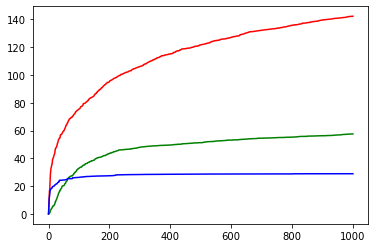

In [4]:
Regret_Perceptron = np.concatenate(([0], Regret_Perceptron))
Regret_OGD = np.concatenate(([0], Regret_OGD))
Regret_MoM = np.concatenate(([0], Regret_MoM))
plt.plot(Regret_Perceptron, color='r')
plt.plot(Regret_OGD, color='g')
plt.plot(Regret_MoM, color='b')

In [15]:
np.savetxt(os.path.join('Online', f"OGD"), Regret_OGD)
np.savetxt(os.path.join('Online', f"Perceptron"), Regret_Perceptron)
np.savetxt(os.path.join('Online', f"MoM"), Regret_MoM)

100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [02:45<00:00,  6.02it/s]


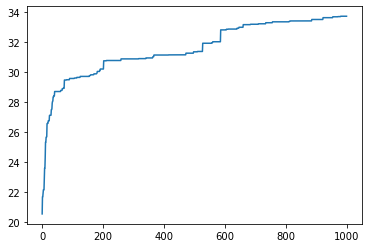

Total wrong decisions 80


In [3]:
Regret_ML = om.OnlineMarginLearning(A=A, b=b, c=c, z=z, basic=basic, nonb=nonb,
                                    regular_const=1e-6, solved=True, solution=solution, show_figure=True, checkpoint = 10)

100%|█████████████████████████████████████████████████████████████████████████| 100000/100000 [08:19<00:00, 200.14it/s]


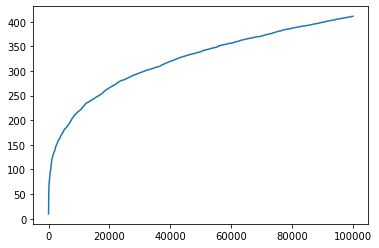

Total wrong decisions 6538


In [10]:
Regret_Perceptron, predict_cost, reduced_cost = om.Perceptron(A, b, c, z, basic, nonb, solved=True, solution=solution, show_figure=True, margin=0.05)

100%|█████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:25<00:00, 198.69it/s]


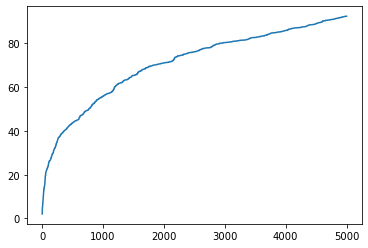

Total wrong decisions 1741


In [6]:
Regret_Perceptron, predict_cost, reduced_cost = om.Perceptron(A, b, c, z, basic, nonb, solved=True, solution=solution, show_figure=True, margin=0.05)

100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:05<00:00, 199.68it/s]


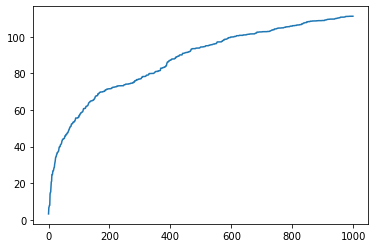

Total wrong decisions 443


C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


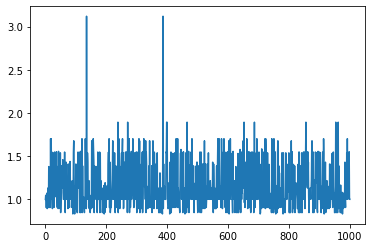

In [2]:
Regret_Perceptron, predict_cost, reduced_cost = om.Perceptron(A, b, c, z, basic, nonb, solved=True, solution=solution, show_figure=True, margin=0.05)

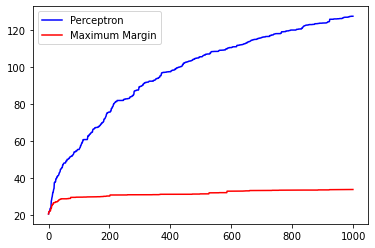

In [8]:
plt.plot(Regret_Perceptron, color='b', label='Perceptron')
plt.plot(Regret_ML, color='r', label='Maximum Margin')
plt.legend()
plt.show()

100%|█████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:29<00:00, 171.21it/s]


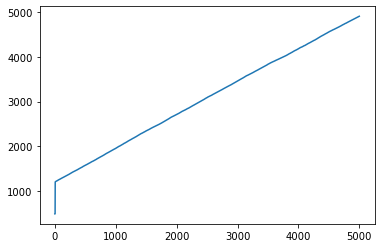

In [5]:
Regret_Perceptron, predict_cost, reduced_cost = om.Perceptron(A, b, mod_c, z, basic, nonb, solved=True, solution=solution, show_figure=True)

100%|████████████████████████████████████████████████████████████████████████████| 5000/5000 [1:28:04<00:00,  1.06s/it]


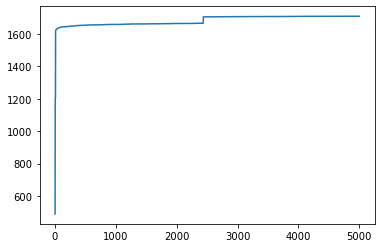

In [6]:
Regret_ML = om.OnlineMarginLearning(A=A, b=b, c=mod_c, z=z, basic=basic, nonb=nonb,
                                    regular_const=1e-6, solved=True, solution=solution, show_figure=True, checkpoint = 20)

100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [02:59<00:00,  5.58it/s]


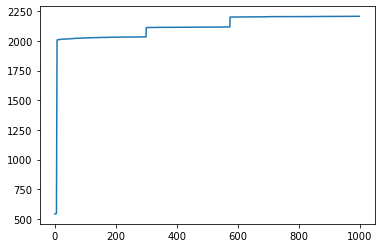

In [4]:
Regret_ML = om.OnlineMarginLearning(A=A, b=b, c=mod_c, z=z, basic=basic, nonb=nonb,
                                    regular_const=1e-6, solved=True, solution=solution, show_figure=True, checkpoint = 10)

100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [02:50<00:00,  5.87it/s]


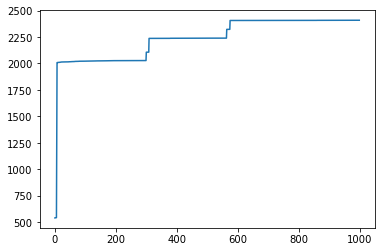

In [5]:
Regret_ML = om.OnlineMarginLearning(A=A, b=b, c=mod_c, z=z, basic=basic, nonb=nonb,
                                    regular_const=1e-4, solved=True, solution=solution, show_figure=True, checkpoint = 10)